In [40]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go
from tensorflow.keras.callbacks import EarlyStopping


In [41]:
df = pd.read_csv('//content/ec2_cpu_utilization_24ae8d.csv')
df = df[['timestamp', 'value']]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['timestamp'], y=df['value'], name='cpu usage'))
fig.update_layout(showlegend=True, title='cpu usage')
fig.show()

In [43]:
print("Start date is: ", df['timestamp'].min())
print("End date is: ", df['timestamp'].max())


Start date is:  2014-02-14 14:30:00
End date is:  2014-02-28 14:25:00


# **Data Preprocessing**:

In [44]:
train = df.loc[df['timestamp'] <= '2014-02-25 14:30:00']
test = df.loc[df['timestamp'] > '2014-02-25 14:30:00']
train.shape, test.shape

((3169, 2), (863, 2))

In [45]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.array(train['value']).reshape(-1,1))

train['value'] = scaler.transform(np.array(train['value']).reshape(-1,1))
test['value'] = scaler.transform(np.array(test['value']).reshape(-1,1))

<ipython-input-45-f4929c09a8c1>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-45-f4929c09a8c1>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



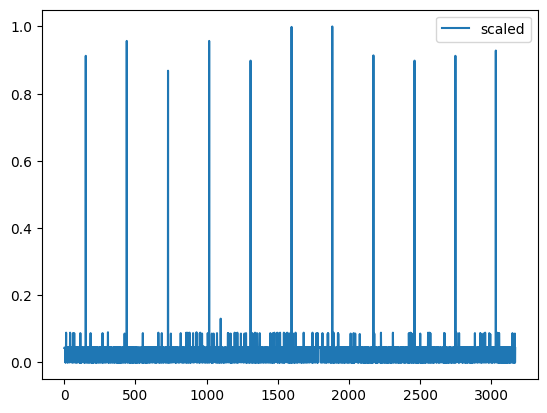

In [46]:
plt.plot(train['value'], label = 'scaled')
plt.legend()
plt.show()

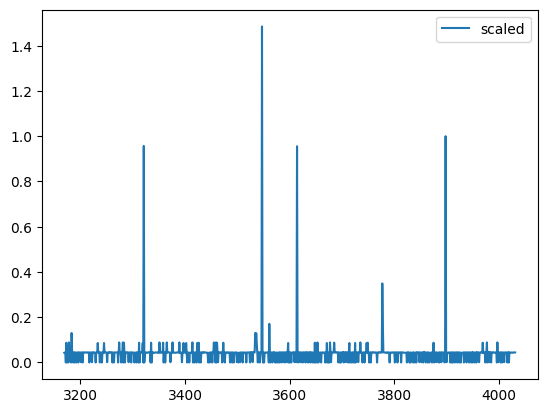

In [47]:
plt.plot(test['value'], label = 'scaled')
plt.legend()
plt.show()

In [48]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])

    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['value']], train['value'])
X_test, y_test = create_sequences(test[['value']], test['value'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (3139, 30, 1)
Testing input shape:  (833, 30, 1)


In [49]:
X_train[3138]

array([[0.04432855],
       [0.04432855],
       [0.00130378],
       [0.04432855],
       [0.04432855],
       [0.04302477],
       [0.        ],
       [0.04302477],
       [0.00130378],
       [0.04302477],
       [0.04432855],
       [0.08735332],
       [0.        ],
       [0.04432855],
       [0.04432855],
       [0.04302477],
       [0.04432855],
       [0.        ],
       [0.04432855],
       [0.04302477],
       [0.04432855],
       [0.        ],
       [0.04302477],
       [0.04432855],
       [0.04432855],
       [0.        ],
       [0.04563233],
       [0.        ],
       [0.08604954],
       [0.        ]])

## **Build a model**

In [50]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_2 (RepeatVec  (None, 30, 128)           0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_5 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_2 (TimeDi  (None, 30, 1)             129       
 stributed)                                           

# **Train Model**

In [51]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
89/89 [==============================] - 14s 110ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 2/100
89/89 [==============================] - 10s 110ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 3/100
89/89 [==============================] - 8s 94ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 4/100
89/89 [==============================] - 9s 103ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 5/100
89/89 [==============================] - 10s 109ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 6/100
89/89 [==============================] - 8s 87ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 7/100
89/89 [==============================] - 10s 109ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 8/100
89/89 [==============================] - 10s 108ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 9/100
89/89 [==============================] - 8s 87ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 10/100
89/89 [==============================] - 10s 110ms/step - loss: 0.0033 - val

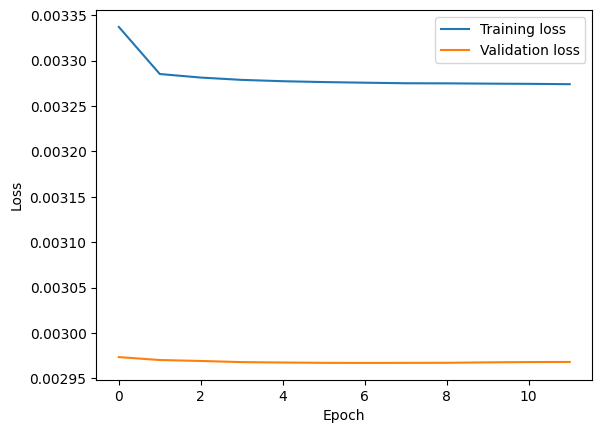

In [52]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

99/99 [==============================] - 4s 29ms/step
Reconstruction error threshold: 0.05120872127969644


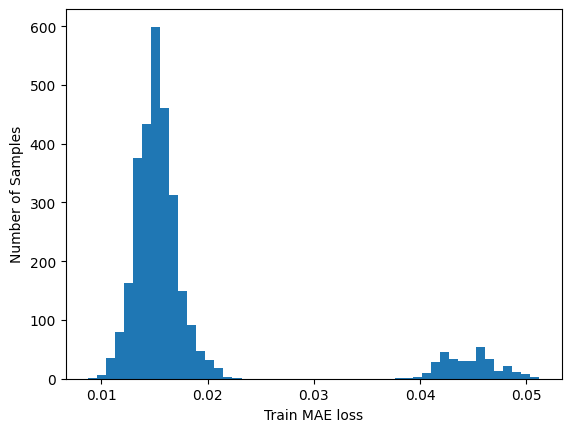

In [53]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

# **Predict Anomalies on test data using threshold**

27/27 [==============================] - 1s 29ms/step


Text(0, 0.5, 'Number of samples')

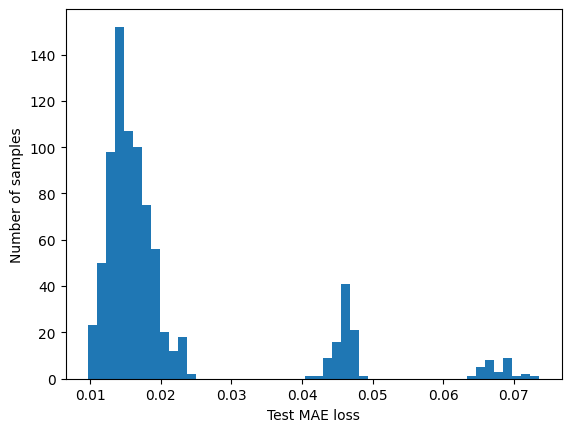

In [54]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [55]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [56]:
anomaly_df.head()

,timestamp,value,loss,threshold,anomaly
3199,2014-02-25 17:05:00,0.044329,0.020833,0.051209,False
3200,2014-02-25 17:10:00,0.043025,0.020854,0.051209,False
3201,2014-02-25 17:15:00,0.001304,0.020809,0.051209,False
3202,2014-02-25 17:20:00,0.044329,0.021916,0.051209,False
3203,2014-02-25 17:25:00,0.044329,0.020904,0.051209,False


In [57]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [58]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,timestamp,value,loss,threshold,anomaly
3548,2014-02-26 22:10:00,0.044329,0.067251,0.051209,True
3549,2014-02-26 22:15:00,0.000000,0.063501,0.051209,True
3550,2014-02-26 22:20:00,0.044329,0.065630,0.051209,True
3551,2014-02-26 22:25:00,0.000000,0.067071,0.051209,True
3552,2014-02-26 22:30:00,0.043025,0.069280,0.051209,True


In [59]:
anomalies.shape

(30, 5)

In [60]:
anomaly_values = anomaly_df['value'].values.reshape(-1, 1)
anomaly_inverse_values = scaler.inverse_transform(anomaly_values)

anomalies_values = anomalies['value'].values.reshape(-1, 1)
anomalies_inverse_values = scaler.inverse_transform(anomalies_values)

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_inverse_values.flatten(), name='cpu usage'))
fig.add_trace(go.Scatter(x=anomalies['timestamp'], y=anomalies_inverse_values.flatten(), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()
